# Overlap Correction with Linear Mixed Models (aka unmixed.jl)
### Benedikt Ehinger with help from Dave Kleinschmidt
### 2020-02-17

In [3]:
using Revise
using CSV
using StatsModels
using MixedModels
using DataFrames
using DataFramesMeta
import Plots
import unfold
using Gadfly
using DataFramesMeta

Plots.gr()

Plots.GRBackend()

This notebook is similar to the `lm_tutorial`, but fits mass-univariate *mixed* models and time-expanded/overlap-corrected *mixed* models.

## Reading input
The data were simulated in MatLab using the `unmixed toolbox (www.unfoldtoolbox.org)` with the function`EEG_to_csv.m`.

**Limitation**: due to current implementation in MixedModels.jl, we cannot fit overlap-corrected random effects.
That is, the `(1|item)` cannot be modelled at the moment.

In [4]:
testCase = "testCaseMultisubject2"
data = CSV.read("..\\test\\"*testCase*"_data.csv", header=0)
data = convert(Array,data)
evts = CSV.read("..\\test\\"*testCase*"_events.csv")
categorical!(evts,:subject);

The `events` dataFrame looks like this

In [5]:
first(evts,6)

,type,latency,trialnum,condA,condB,stimulus,subject,urlatency
,String,Int64,Int64,Int64,Int64,Int64,Categorical…,Int64
1,sim,20,1,0,1,4,1,20
2,sim,33,2,0,0,5,1,33
3,sim,50,3,0,1,2,1,50
4,sim,66,4,1,0,9,1,66
5,sim,72,5,0,1,6,1,72
6,sim,85,6,1,0,8,1,85


With the important fields being `latency`, `condA`, `condB` and `subject`.

The data are a vector.

In [6]:
println(typeof(data))
println(size(data))

Array{Float64,2}
(1, 11797)


**Limitation** Note how small it is! Only 12k samples, that is only ~5minutes of recording in total for 25 subjects. More realistic samples quickly take hours to fit.

## Without Overlap Correction
We define the formula

In [7]:
f  = @formula 0~1+condA*condB+(1+condA*condB|subject);

epoch the data once again

In [8]:
data_r = reshape(data,(1,:))
# cut the data into epochs
data_epochs,times = unfold.epoch(data=data_r,tbl=evts,τ=(-0.4,0.8),sfreq=50);

We can now run the LinearMixedModel on each time point

In [10]:
@time m = unfold.fit(unfold.UnfoldLinearMixedModel,f,evts,data_epochs,times)

  2.984649 seconds (5.44 M allocations: 184.157 MiB, 2.39% gc time)


UnfoldModel
Unique Terms: SubString{String}["(Intercept)", "condA", "condB", "condA & condB"]
Times: -0.4 : 0.8


And plot it:

In [11]:
d = @linq m.results |> where(:group.=="fixed")
plot(d,x=:time,y=:estimate,color=:term,Geom.LineGeometry)

And the random effect results

In [12]:
d = @linq m.results |> where(:group.=="subject")
plot(d,x=:time,y=:estimate,color=:term,Geom.LineGeometry)

Obviously there is still something wrong with the random effects - but we are getting there :-D

## With Overlap Correction
For overlap correction, we have to use a basis function once again.

In [13]:
basisfunction = unfold.firbasis(τ=(-0.05,.4),sfreq=40)
f  = @formula 0~1+condA*condB+(1+condA*condB|subject);

**Limitation:** Currently we cannot model correlation between time-points or random slopes.

**Limitation:** See the low sampling frequency? This is because the modelfit increases quadratically with the number of predictors

We can now run the mixed model.

Easy syntax: Specify formula, events, EEG-data & the basis function

In [14]:
@time mm = unfold.fit(unfold.UnfoldLinearMixedModel,f,evts,data,basisfunction)

 92.874327 seconds (10.19 M allocations: 2.116 GiB, 0.34% gc time)


UnfoldModel
Unique Terms: SubString{String}["(Intercept)", "condA", "condB", "condA & condB"]
Times: -0.05 : 0.4


We receive an object containing the mixed model:

In [15]:
show(coeftable(mm.model))

────────────────────────────────────────────────────────────────
                           Estimate  Std.Error  z value  P(>|z|)
────────────────────────────────────────────────────────────────
(Intercept) : -0.05      0.482792     0.479356     1.01   0.3139
(Intercept) : -0.025     0.456136     0.482433     0.95   0.3444
(Intercept) : 0.0       -0.860991     0.478256    -1.80   0.0718
(Intercept) : 0.025      0.523212     0.478135     1.09   0.2738
(Intercept) : 0.05       2.63189      0.502494     5.24   <1e-6 
(Intercept) : 0.075      4.24724      0.52939      8.02   <1e-14
(Intercept) : 0.1        0.728094     0.47708      1.53   0.1270
(Intercept) : 0.125     -1.08884      0.474746    -2.29   0.0218
(Intercept) : 0.15      -3.44011      0.536694    -6.41   <1e-9 
(Intercept) : 0.175     -3.00565      0.4964      -6.05   <1e-8 
(Intercept) : 0.2       -1.19316      0.47089     -2.53   0.0113
(Intercept) : 0.225      3.53461      0.471289     7.50   <1e-13
(Intercept) : 0.25       

In [16]:
mm.model

Linear mixed model fit by maximum likelihood
 0 ~ ["(Intercept) : -0.05", "(Intercept) : -0.025", "(Intercept) : 0.0", "(Intercept) : 0.025", "(Intercept) : 0.05", "(Intercept) : 0.075", "(Intercept) : 0.1", "(Intercept) : 0.125", "(Intercept) : 0.15", "(Intercept) : 0.175", "(Intercept) : 0.2", "(Intercept) : 0.225", "(Intercept) : 0.25", "(Intercept) : 0.275", "(Intercept) : 0.3", "(Intercept) : 0.325", "(Intercept) : 0.35", "(Intercept) : 0.375", "(Intercept) : 0.4", "condA : -0.05", "condA : -0.025", "condA : 0.0", "condA : 0.025", "condA : 0.05", "condA : 0.075", "condA : 0.1", "condA : 0.125", "condA : 0.15", "condA : 0.175", "condA : 0.2", "condA : 0.225", "condA : 0.25", "condA : 0.275", "condA : 0.3", "condA : 0.325", "condA : 0.35", "condA : 0.375", "condA : 0.4", "condB : -0.05", "condB : -0.025", "condB : 0.0", "condB : 0.025", "condB : 0.05", "condB : 0.075", "condB : 0.1", "condB : 0.125", "condB : 0.15", "condB : 0.175", "condB : 0.2", "condB : 0.225", "condB : 0.25", "c

The VarCor - Random effect matrix is very large, so we are not showing it here.

But we also get a *tidy*-dataframe with the results

In [17]:
first(mm.results,6)

,term,estimate,stderror,group,time
,SubStrin…,Float64,Float64,Any,Float64
1,(Intercept),0.482792,0.479356,fixed,-0.05
2,(Intercept),0.456136,0.482433,fixed,-0.025
3,(Intercept),-0.860991,0.478256,fixed,0.0
4,(Intercept),0.523212,0.478135,fixed,0.025
5,(Intercept),2.63189,0.502494,fixed,0.05
6,(Intercept),4.24724,0.52939,fixed,0.075


and thus we can easily plot the fixed effect results.

In [18]:
d = @linq mm.results |> where(:group.=="fixed")
plot(d,x=:time,y=:estimate,color=:term,Geom.LineGeometry)

And the random effect results.

In [19]:
d = @linq mm.results |> where(:group.=="subject")
plot(d,x=:time,y=:estimate,color=:term,Geom.LineGeometry)

## What is happening under the hood?

In [20]:
Xs,form = unfold.LinearMixedModel_formula(f,evts,basisfunction, contrasts = Dict{Symbol,Any}());

Formula-Terms are wrapped with a `TimeExpandedTerm`, which upon calling `modelcols` will timeexpand the designmatrix.
There is one TimeExpandedTerm for the FixedEffects and one for each RandomEffectsTerm.

 **Limitation** Currently it is not possible to combine different formulas & different basis-functions, but that is planned

In [22]:
typeof(form.rhs)

Tuple{unfold.TimeExpandedTerm{MatrixTerm{Tuple{InterceptTerm{true},ContinuousTerm{Float64},ContinuousTerm{Float64},InteractionTerm{Tuple{ContinuousTerm{Float64},ContinuousTerm{Float64}}}}}},unfold.TimeExpandedTerm{RandomEffectsTerm}}

In [25]:
form.rhs[1].basisfunction

times: -0.05:0.025:0.4
kernel: firkernel


Visualizing the designmatrices.
Fixed Effects:

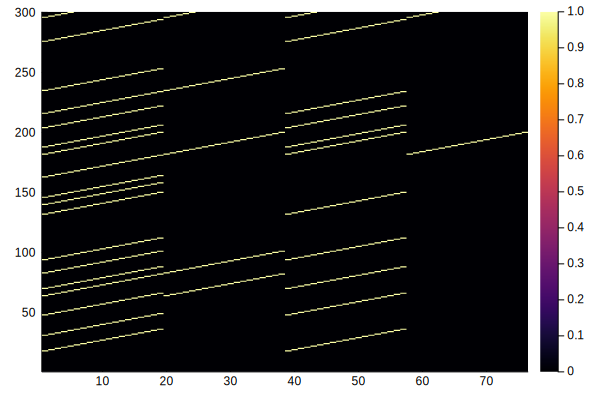

In [26]:
Plots.heatmap(Matrix(Xs[1][1:300,:]))

Random Effects

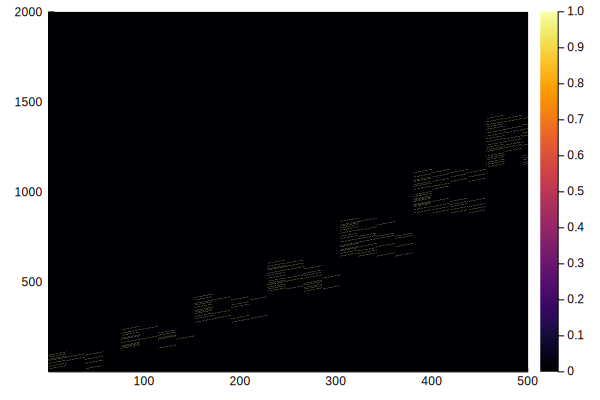

In [27]:
Plots.heatmap(Matrix(Xs[2][1:2000,1:500]))

And finally, generate the linear mixed model manually & fit it.

In [ ]:
mm = unfold.LinearMixedModel_wrapper(form,data,Xs)
fit!(mm)
mm = unfold.condense(mm,evts)

## Summary
There are four different model types currently "fitable"

1. Timeexpansion **No**, Mixed **No**  : `unfold.fit(unfold.UnfoldLinearModel,f,evts,data_epoch,times)`
1. Timeexpansion **Yes**, Mixed **No** : `unfold.fit(unfold.UnfoldLinearModel,f,evts,data,basisfunction)`
1. Timeexpansion **No**, Mixed **Yes** : `unfold.fit(unfold.UnfoldLinearMixedModel,f,evts,data_epoch,times)`
1. Timeexpansion **Yes**, Mixed **Yes**: `unfold.fit(unfold.UnfoldLinearMixedModel,f,evts,data,basisfunction)`

In [ ]:
using Weave

# convert to html
weave("doc\\lmm_tutorial.jmd")

# convert to a python notebook
convert_doc("doc\\lmm_tutorial.jmd", "doc\\lmm_tutorial.ipynb")

# convert to md for README
#weave("doc\\lm_tutorial.jmd", doctype="pandoc", out_path = "README.md")